# Unsupervised Learning Technique (Anomaly detection)

This notebook show how Unsupervised Machine Learning techniques can be used to predict the Loan defaulters

Algorithms used:<br>
Isolation Forest<br>
Local Outlier Factor<br>
Principal Component Analysis (PCA)<br>
Kernel Principal Component Analysis (Kernel PCA)

### Load the data

In [1]:
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import sys
import warnings
warnings.filterwarnings("ignore")

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [2]:
application_train = pd.read_csv('cleandata.csv')

## Modeling

### Partitioning

In [3]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = application_train[application_train['TARGET']==1]

Valid = application_train[application_train['TARGET']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

print('outlier_fraction for the whole dataset:')
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

outlier_fraction for the whole dataset:
0.08781828601345662
Fraud Cases : 24825
Valid Cases : 282686


In [4]:
from sklearn.model_selection import train_test_split

#Create independent and Dependent Features
columns = application_train.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["TARGET"]]
# Store the variable we are predicting 
target = "TARGET"
# Define a random state 
state = np.random.RandomState(42)
X = application_train[columns]
y = application_train[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(246008, 210) (246008,)
(61503, 210) (61503,)


### More Feature Selection

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [6]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100, random_state=state))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(random_state=RandomState(MT19937) at 0x1D4148DDD08))

In [7]:
sel.get_support()

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False, False, False,  True,
        True, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True, False,  True,  True, False,  True,  True,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,

In [8]:
selected_feat= X_train.columns[(sel.get_support())].tolist()
len(selected_feat)

42

In [9]:
print(selected_feat)

['FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAREA_AVG', 'TOTALAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_FAMILY_STATUS_Married', 'OCCUPATION_TYPE_Laborers', 'CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']


In [10]:
app_X_train = X_train.copy() #Taking a copy before dropping 
app_X_test = X_test.copy()

In [11]:
X_train = X_train[selected_feat]
X_test = X_test[selected_feat]

In [12]:
print (X_train.shape, X_test.shape)

(246008, 42) (61503, 42)


------------------------------

In [13]:
from sklearn.metrics import classification_report,accuracy_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

### Isolation Forest

In [14]:
clf = IsolationForest(n_estimators= 120, max_samples=len(X_train), contamination=outlier_fraction, random_state=state, verbose=0)

In [15]:
clf.fit(X_train,y_train)

IsolationForest(contamination=0.08781828601345662, max_samples=246008,
                n_estimators=120,
                random_state=RandomState(MT19937) at 0x1D4148DDD08)

Text(0.5, 1.0, 'Histogram of Avg Anomaly Scores: Lower => More Anomalous')

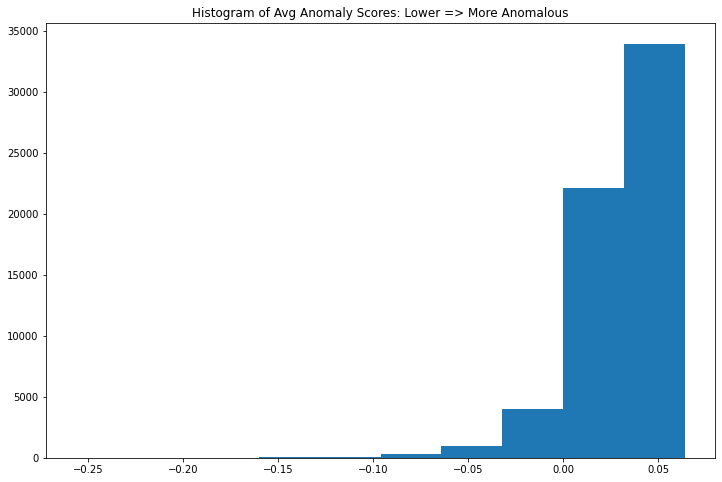

In [16]:
if_scores = clf.decision_function(X_test)
plt.figure(figsize=(12,8))

plt.hist(if_scores)
plt.title('Histogram of Avg Anomaly Scores: Lower => More Anomalous')

In [17]:
y_pred = clf.predict(X_test)

In [18]:
#Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
n_errors = (y_pred != y_test).sum()

In [19]:

# Run Classification Metrics
print("{}: {}".format("Isolation Forest errors",n_errors))
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred))
print("Confusion matrix :")
print(confusion_matrix(y_test, y_pred))
print("Classification Report :")
print(classification_report(y_test,y_pred))
print("ROC AUC score is: ",roc_auc_score(y_test,y_pred))

Isolation Forest errors: 9782
Accuracy Score :
0.8409508479261174
Confusion matrix :
[[51388  5070]
 [ 4712   333]]
Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     56458
           1       0.06      0.07      0.06      5045

    accuracy                           0.84     61503
   macro avg       0.49      0.49      0.49     61503
weighted avg       0.85      0.84      0.84     61503

ROC AUC score is:  0.48810233914114776


### Local Outlier Factor

In [20]:
lof = LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination = outlier_fraction, novelty=True) #novelty = True to test on unseen data

In [21]:
lof.fit(X_train,y_train)

LocalOutlierFactor(contamination=0.08781828601345662, novelty=True)

In [22]:
y_pred = lof.predict(X_test)

Text(0.5, 1.0, 'Histogram of Avg Anomaly Scores: Higher => More Anomalous')

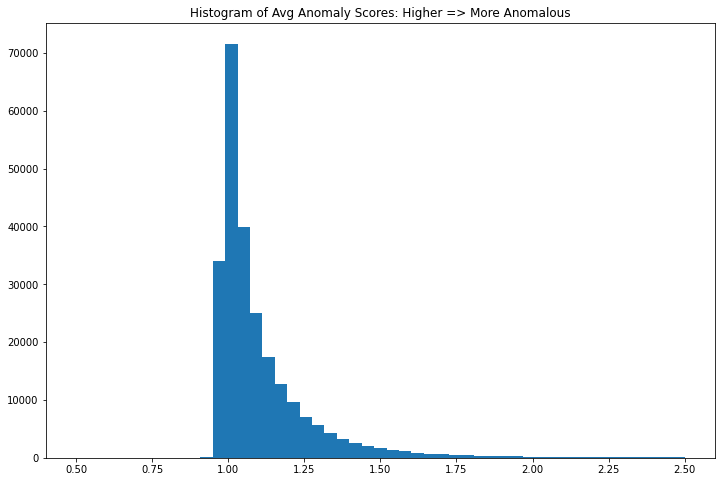

In [23]:
LOF_Scores = lof.negative_outlier_factor_
plt.figure(figsize=(12,8))

bins = np.linspace(0.5, 2.5)
plt.hist(-LOF_Scores, bins)
plt.title('Histogram of Avg Anomaly Scores: Higher => More Anomalous')


In [24]:
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
n_errors = (y_pred != y_test).sum()
# Run Classification Metrics
print("{}: {}".format("Local Outlier Factor errors",n_errors))
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred))
print("Confusion matrix :")
print(confusion_matrix(y_test, y_pred))
print("Classification Report :")
print(classification_report(y_test,y_pred))
print("ROC AUC score is: ",roc_auc_score(y_test,y_pred))

Local Outlier Factor errors: 9756
Accuracy Score :
0.8413735915321204
Confusion matrix :
[[51302  5156]
 [ 4600   445]]
Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     56458
           1       0.08      0.09      0.08      5045

    accuracy                           0.84     61503
   macro avg       0.50      0.50      0.50     61503
weighted avg       0.85      0.84      0.85     61503

ROC AUC score is:  0.49844081013624203


### PCA

In [25]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

from sklearn.metrics import roc_curve
from sklearn.metrics import auc


In [26]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

In [27]:
def plotResults(trueLabels, anomalyScores, returnPreds = False):
    preds = pd.concat([trueLabels, anomalyScores], axis=1)
    preds.columns = ['trueLabel', 'anomalyScore']
    precision, recall, thresholds = \
        precision_recall_curve(preds['trueLabel'],preds['anomalyScore'])
    average_precision = \
        average_precision_score(preds['trueLabel'],preds['anomalyScore'])

    plt.step(recall, precision, color='k', alpha=0.7, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

    plt.title('Precision-Recall curve: Average Precision = \
    {0:0.2f}'.format(average_precision))

    fpr, tpr, thresholds = roc_curve(preds['trueLabel'], \
                                     preds['anomalyScore'])
    areaUnderROC = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: \
    Area under the curve = {0:0.2f}'.format(areaUnderROC))
    plt.legend(loc="lower right")
    plt.show()

    if returnPreds==True:
        return preds

In [28]:
def scatterPlot(xDF, yDF, algoName):
    tempDF = pd.DataFrame(data=xDF.loc[:,0:1], index=xDF.index)
    tempDF = pd.concat((tempDF,yDF), axis=1, join="inner")
    tempDF.columns = ["First Vector", "Second Vector", "Label"]
    sns.lmplot(x="First Vector", y="Second Vector", hue="Label", \
               data=tempDF, fit_reg=False)
    ax = plt.gca()
    ax.set_title("Separation of Observations using "+algoName)

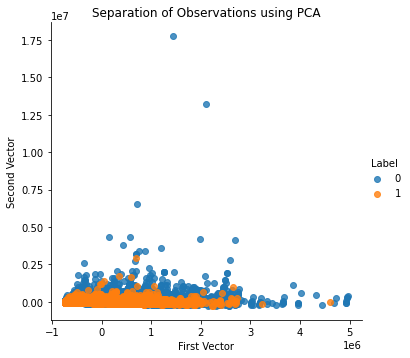

In [29]:
from sklearn.decomposition import PCA

n_components = 22
whiten = False
random_state = state

pca = PCA(n_components=n_components, whiten=whiten, \
          random_state=random_state)

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(data=X_train_PCA, index=X_train.index)

X_train_PCA_inverse = pca.inverse_transform(X_train_PCA)
X_train_PCA_inverse = pd.DataFrame(data=X_train_PCA_inverse, \
                                   index=X_train.index)

scatterPlot(X_train_PCA, y_train, "PCA")

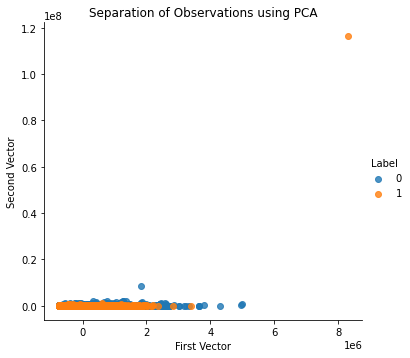

In [30]:
# PCA on Test Set
X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(data=X_test_PCA, index=X_test.index)

X_test_PCA_inverse = pca.inverse_transform(X_test_PCA)
X_test_PCA_inverse = pd.DataFrame(data=X_test_PCA_inverse, \
                                  index=X_test.index)

scatterPlot(X_test_PCA, y_test, "PCA")

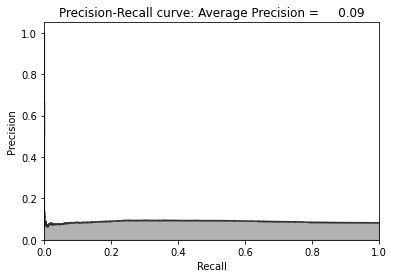

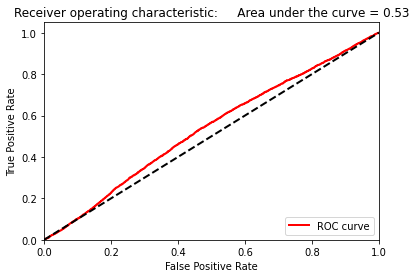

In [31]:
anomalyScoresPCA = anomalyScores(X_test, X_test_PCA_inverse)
preds = plotResults(y_test, anomalyScoresPCA, True)

In [32]:
X_test

,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAREA_AVG,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_FAMILY_STATUS_Married,OCCUPATION_TYPE_Laborers,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT
86288,1,0,112500.0,1585224.0,42637.5,1350000.0,20938,-1648.0,-7501.0,-4100,9.0,2.0,2,0.505998,0.663817,0.832785,0.0124,0.0763,0.9692,0.7552,0.0211,0.0690,0.0417,0.2083,0.0481,0.0756,0.0130,0.0000,0.0103,0.0,0.0,0.0,-221.0,0.0,0.0,3.0,1,1,14.090880,0.379000,0.026897,-0.078709
283264,0,0,360000.0,1724688.0,54283.5,1575000.0,13812,-282.0,-549.0,-5478,18.0,2.0,2,0.796995,0.574332,0.746300,0.0464,0.0763,0.9851,0.7552,0.0211,0.1379,0.1667,0.2083,0.0481,0.0756,0.0440,0.0036,0.0346,0.0,0.0,0.0,-1295.0,0.0,0.0,1.0,1,0,4.790800,0.150787,0.031474,-0.020417
52711,1,1,135000.0,270000.0,13500.0,450000.0,13482,-2405.0,-3893.0,-3559,9.0,3.0,1,0.505998,0.703034,0.729567,0.0742,0.0763,0.9866,0.7552,0.0211,0.0690,0.3333,0.2083,0.0481,0.0756,0.0773,0.0000,0.0608,1.0,0.0,0.0,-898.0,0.0,0.0,2.0,1,1,2.000000,0.100000,0.050000,-0.178386
153779,1,0,76500.0,728460.0,38808.0,675000.0,21096,-9022.0,-4658.0,-3340,9.0,2.0,3,0.695161,0.418987,0.540654,0.0876,0.0763,0.9816,0.7552,0.0211,0.1379,0.1667,0.2083,0.0481,0.0756,0.0745,0.0036,0.0688,0.0,0.0,0.0,-1038.0,0.0,1.0,1.0,1,0,9.522353,0.507294,0.053274,-0.427664
269045,1,0,360000.0,1475154.0,54796.5,1377000.0,17550,-2877.0,-1240.0,-1058,9.0,1.0,2,0.385116,0.687929,0.739412,0.0861,0.0490,0.9762,0.6736,0.0241,0.0862,0.1875,0.2292,0.1188,0.0698,0.0584,0.0011,0.0195,2.0,0.0,2.0,-573.0,12.0,0.0,1.0,0,1,4.097650,0.152213,0.037146,-0.163932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146224,1,1,225000.0,1561500.0,45787.5,1561500.0,16937,-1090.0,-7189.0,-470,14.0,3.0,1,0.505998,0.812593,0.822499,0.0165,0.0000,0.9662,0.5376,0.0273,0.1379,0.0417,0.0417,0.0521,0.0134,0.0227,0.0000,0.0328,0.0,0.0,0.0,-399.0,0.0,0.0,3.0,1,1,6.940000,0.203500,0.029323,-0.064356
75232,0,0,270000.0,1006920.0,39933.0,900000.0,20857,-1971.0,-5366.0,-3857,9.0,2.0,2,0.505998,0.747020,0.716570,0.0619,0.0629,0.9806,0.7348,0.0224,0.1379,0.1667,0.0000,0.0000,0.0496,0.0365,0.0562,0.0409,1.0,0.0,1.0,-470.0,0.0,0.0,1.0,1,0,3.729333,0.147900,0.039659,-0.094501
224453,0,0,247500.0,521280.0,23089.5,450000.0,13940,-834.0,-7915.0,-4755,9.0,2.0,2,0.455670,0.593435,0.590233,0.0722,0.0634,0.9796,0.7212,0.0267,0.1379,0.1667,0.0417,0.0175,0.0756,0.0695,0.0000,0.0693,0.0,0.0,0.0,-1311.0,0.0,0.0,2.0,1,0,2.106182,0.093291,0.044294,-0.059828
240027,1,0,270000.0,966555.0,51628.5,913500.0,20082,-2722.0,-2985.0,-3628,9.0,2.0,2,0.505998,0.702833,0.586740,0.0876,0.0763,0.9816,0.7552,0.0211,0.1379,0.1667,0.2083,0.0481,0.0756,0.0745,0.0036,0.0688,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1,0,3.579833,0.191217,0.053415,-0.135544


In [33]:
anomalyScore=pd.DataFrame(anomalyScoresPCA, columns=['y_scores']) 

In [34]:
anomalyScore.loc[anomalyScore['y_scores'] <= 0.06, 'y_pred'] = 0
anomalyScore.loc[anomalyScore['y_scores'] > 0.06, 'y_pred'] =  1


In [35]:
y_pred = anomalyScore['y_pred']

In [36]:
n_errors = (y_pred != y_test).sum()
# Run Classification Metrics
print("{}: {}".format("PCA  errors",n_errors))
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred))
print("Confusion matrix :")
print(confusion_matrix(y_test, y_pred))
print("Classification Report :")
print(classification_report(y_test,y_pred))
print("ROC AUC score is: ",roc_auc_score(y_test,y_pred))

PCA  errors: 5044
Accuracy Score :
0.917987740435426
Confusion matrix :
[[56458     0]
 [ 5044     1]]
Classification Report :
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56458
           1       1.00      0.00      0.00      5045

    accuracy                           0.92     61503
   macro avg       0.96      0.50      0.48     61503
weighted avg       0.92      0.92      0.88     61503

ROC AUC score is:  0.5000991080277503


## KERNEL PCA

In [37]:
# Kernel PCA
from sklearn.decomposition import KernelPCA

n_components = 22
kernel = 'rbf'
gamma = None
fit_inverse_transform = True
random_state = state
n_jobs = 1

kernelPCA = KernelPCA(n_components=n_components, kernel=kernel, \
                gamma=gamma, fit_inverse_transform= \
                fit_inverse_transform, n_jobs=n_jobs, \
                random_state=random_state)


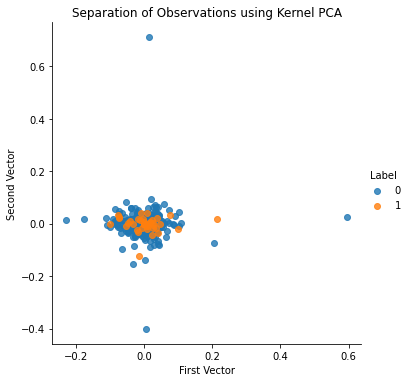

In [38]:
kernelPCA.fit(X_train.iloc[:400])
X_train_kernelPCA = kernelPCA.transform(X_train)
X_train_kernelPCA = pd.DataFrame(data=X_train_kernelPCA, \
                                 index=X_train.index)

X_train_kernelPCA_inverse = kernelPCA.inverse_transform(X_train_kernelPCA)
X_train_kernelPCA_inverse = pd.DataFrame(data=X_train_kernelPCA_inverse, \
                                         index=X_train.index)

scatterPlot(X_train_kernelPCA, y_train, "Kernel PCA")

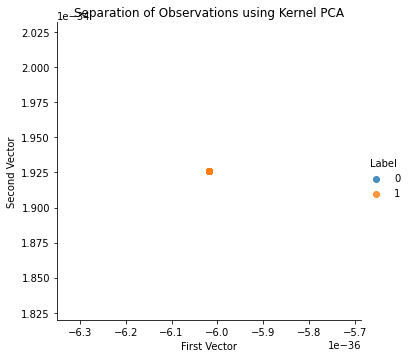

In [39]:
# PCA on Test Set
X_test_kernelPCA = kernelPCA.transform(X_test)
X_test_kernelPCA = pd.DataFrame(data=X_test_kernelPCA, index=X_test.index)

X_test_kernelPCA_inverse = kernelPCA.inverse_transform(X_test_kernelPCA)
X_test_kernelPCA_inverse = pd.DataFrame(data=X_test_kernelPCA_inverse, \
                                  index=X_test.index)

scatterPlot(X_test_kernelPCA, y_test, "Kernel PCA")

In [40]:
anomalyScoreskernelPCA = anomalyScores(X_test,X_test_kernelPCA_inverse)

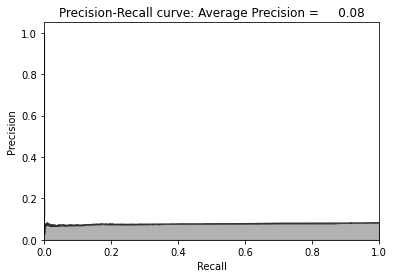

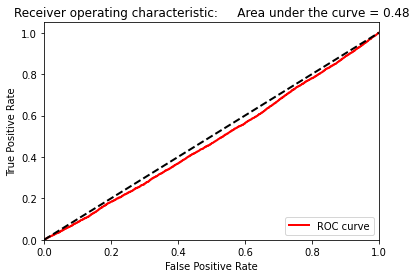

In [41]:
preds = plotResults(y_test, anomalyScoreskernelPCA, True)
anomalyScore=pd.DataFrame(anomalyScoreskernelPCA, columns=['y_scores']) 

In [42]:
anomalyScore.loc[anomalyScore['y_scores'] <= 0.06, 'y_pred'] = 0
anomalyScore.loc[anomalyScore['y_scores'] > 0.06, 'y_pred'] =  1
y_pred = anomalyScore['y_pred']

In [43]:
n_errors = (y_pred != y_test).sum()
# Run Classification Metrics
print("{}: {}".format("Kernel PCA  errors",n_errors))
print("Accuracy Score :")
print(accuracy_score(y_test,y_pred))
print("Confusion matrix :")
print(confusion_matrix(y_test, y_pred))
print("Classification Report :")
print(classification_report(y_test,y_pred))
print("ROC AUC score is: ",roc_auc_score(y_test,y_pred))

Kernel PCA  errors: 5044
Accuracy Score :
0.917987740435426
Confusion matrix :
[[56458     0]
 [ 5044     1]]
Classification Report :
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56458
           1       1.00      0.00      0.00      5045

    accuracy                           0.92     61503
   macro avg       0.96      0.50      0.48     61503
weighted avg       0.92      0.92      0.88     61503

ROC AUC score is:  0.5000991080277503
